In [72]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [73]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Set class number to train for

In [74]:
KEEP_CLASS_NUMBER = 8

### General functions

In [75]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

In [76]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [77]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

#### CNN structure

In [78]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 3
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

#### Isolation forest

In [79]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=SEED
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)

    return anomaly_scores, predictions

In [80]:
def get_outlier_stats(X, y, outlier_indices, anomaly_scores):
    X_outliers = X[outlier_indices]
    y_outliers = y[outlier_indices]
    scores = anomaly_scores[outlier_indices]
    df_outliers = pd.DataFrame({
        'label': y_outliers.flatten(),
        'score': scores
    })
    
    df_all = pd.DataFrame({
        'label': y_combined.flatten(),
        'score': anomaly_scores
    })
    
    # Group by label and compute mean score
    avg_scores_per_class = df_all.groupby('label')['score'].agg(
        mean_score='mean',
        min_score='min',
        max_score='max',
        std_score='std'
    ).reset_index()
    count_per_class = df_outliers.groupby('label')['score'].agg(
        count='count'
    ).reset_index()
    avg_scores_per_class['class_name'] = avg_scores_per_class['label'].apply(lambda x: class_names[x])
    count_per_class['class_name'] = count_per_class['label'].apply(lambda x: class_names[x])
    return avg_scores_per_class, count_per_class

In [81]:
def show_anomaly_score_plot(anomaly_scores):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

In [82]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_evaluation_report(y_true, y_pred, target_names=['Unknown (OOD)', 'Known']):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Outlier Detection Accuracy: {accuracy*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Load dataset from library

In [83]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [84]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [85]:
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'automobile', 'airplane']

In [86]:
CLASS_NUMBER = 10

## Remap labels for easier handling

In [87]:
label_mapping = {original_class_names.index(name): class_names.index(name) for name in original_class_names}

In [88]:
y_train_mapped = np.vectorize(label_mapping.get)(y_train)
y_test_mapped = np.vectorize(label_mapping.get)(y_test)

# Exclude 2 classes from training
Excluded class: airplane, automobile (last in list)

# Divide into trained and unknown classes

In [89]:
keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train_mapped.flatten(), keep_classes)
test_keep_mask = np.isin(y_test_mapped.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train_mapped.flatten(), other_classes)
test_unknown_mask = np.isin(y_test_mapped.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train_mapped[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test_mapped[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train_mapped[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test_mapped[test_unknown_mask]

In [90]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({4: 5000, 7: 5000, 2: 5000, 0: 5000, 5: 5000, 6: 5000, 1: 5000, 3: 5000})
Test labels and counts: Counter({1: 1000, 6: 1000, 4: 1000, 7: 1000, 3: 1000, 5: 1000, 2: 1000, 0: 1000})
Unknown train labels and counts: Counter({8: 5000, 9: 5000})
Unknown test labels and counts: Counter({9: 1000, 8: 1000})


# Plot class distribution

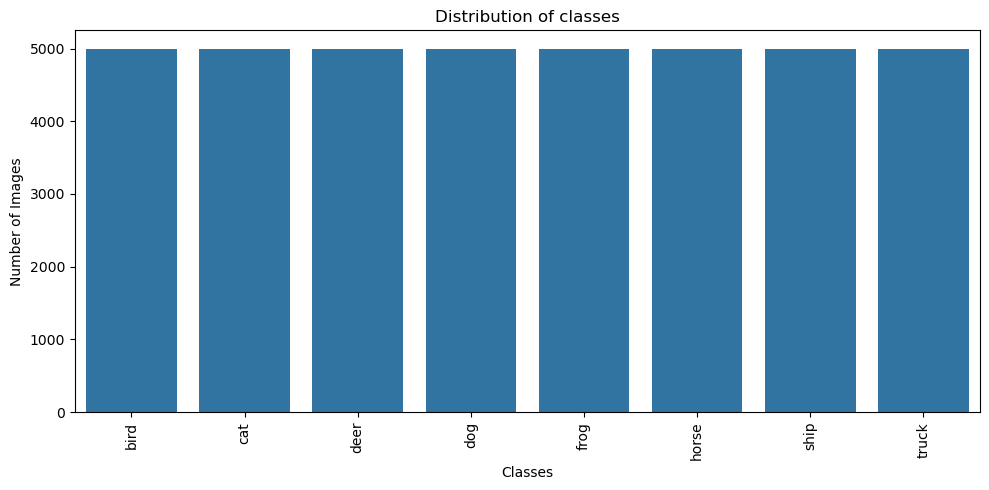

In [91]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

## Known classes

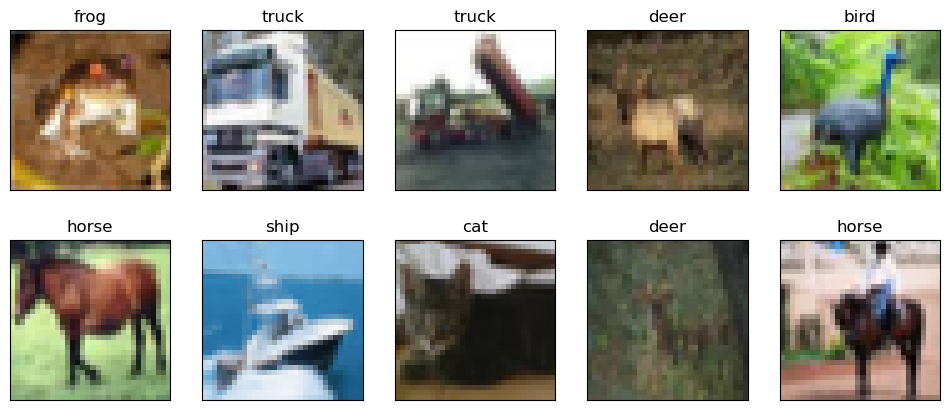

In [92]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

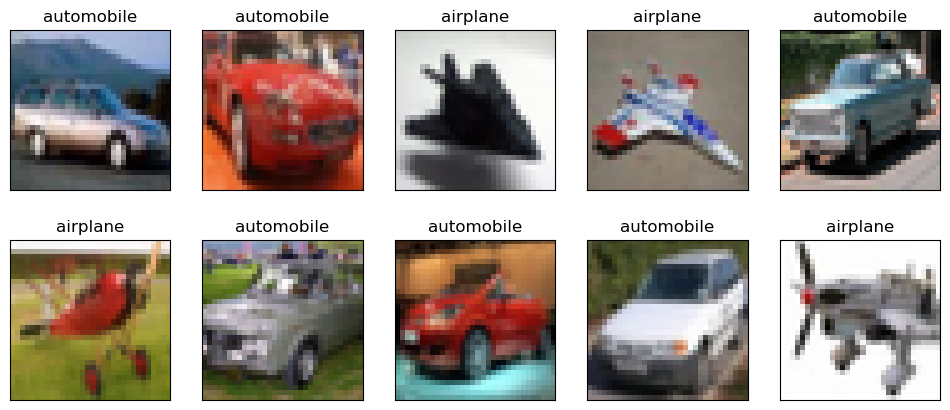

In [93]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [94]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [95]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [96]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=128,
    shuffle=False
)

# Fit simple CNN for classification

In [97]:
my_model = build_simple_cnn()

### Compile model

In [98]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Fit model

In [99]:
my_history = my_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
250/250 [==============================] - 26s 98ms/step - loss: 1.6248 - accuracy: 0.4001 - val_loss: 3.3195 - val_accuracy: 0.1450
Epoch 2/50
250/250 [==============================] - 25s 98ms/step - loss: 1.3228 - accuracy: 0.5125 - val_loss: 1.8215 - val_accuracy: 0.3775
Epoch 3/50
250/250 [==============================] - 24s 97ms/step - loss: 1.1961 - accuracy: 0.5629 - val_loss: 1.1356 - val_accuracy: 0.5855
Epoch 4/50
250/250 [==============================] - 25s 99ms/step - loss: 1.1011 - accuracy: 0.6007 - val_loss: 0.9637 - val_accuracy: 0.6466
Epoch 5/50
250/250 [==============================] - 28s 112ms/step - loss: 1.0265 - accuracy: 0.6277 - val_loss: 0.9475 - val_accuracy: 0.6504
Epoch 6/50
250/250 [==============================] - 31s 124ms/step - loss: 0.9606 - accuracy: 0.6528 - val_loss: 1.0286 - val_accuracy: 0.6384
Epoch 7/50
250/250 [==============================] - 28s 113ms/step - loss: 0.9269 - accuracy: 0.6691 - val_loss: 0.8149 - val_accura

### Save weights to skip training in the future

In [100]:
my_model.save_weights('models/my_model_weights_8_class_v2.keras')

### Simply load saved weights

In [101]:
my_model.load_weights('models/my_model_weights_8_class_v2.keras')

### Evaluate model

In [102]:
loss, accuracy = my_model.evaluate(test_flow, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%, test loss: {loss:.4f}")

63/63 [==============================] - 1s 19ms/step - loss: 0.6391 - accuracy: 0.7936
Test accuracy: 79.36%, test loss: 0.6391


### Get intermediate models

In [103]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Extract features using different layers of the CNN classifier

## Construct datasets for outlier search

### 10% contamination in training set: 4500 known, 500 unknown elements

In [104]:
# Step 1: Get 500 from unknown
X_unknown_subset, _, y_unknown_subset, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 500), random_state=SEED, shuffle=True
)

# Step 2: Get 4500 from filtered
X_filtered_subset, _, y_filtered_subset, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 4500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined = np.concatenate([X_filtered_subset, X_unknown_subset], axis=0)
y_combined = np.concatenate([y_filtered_subset, y_unknown_subset], axis=0)

In [105]:
X_combined.shape, y_combined.shape

((5000, 32, 32, 3), (5000, 1))

In [106]:
subset_train_flow = train_generator.flow(X_combined, y_combined, batch_size=256, shuffle=True, seed=SEED)

### Generate balanaced test data out of 2500 known and 2500 unknown samples

In [107]:
# Step 1: Get 2500 from unknown
X_unknown_subset_test, _, y_unknown_subset_test, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 2500), random_state=SEED, shuffle=True
)

# Step 2: Get 2500 from filtered
X_filtered_subset_test, _, y_filtered_subset_test, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 2500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined_test = np.concatenate([X_filtered_subset_test, X_unknown_subset_test], axis=0)
y_combined_test = np.concatenate([y_filtered_subset_test, y_unknown_subset_test], axis=0)

# Step 4: Create "known vs unknown" labels
is_known = np.concatenate([
    np.ones(len(X_filtered_subset_test)),   # known = 1
    -1 * np.ones(len(X_unknown_subset_test))  # unknown = -1
])

In [108]:
X_combined_test.shape, y_combined_test.shape

((5000, 32, 32, 3), (5000, 1))

In [109]:
subset_test_flow = train_generator.flow(X_combined_test, y_combined_test, batch_size=256, shuffle=False, seed=SEED)

## CNN as feature extractor

In [110]:
train_features_cnn = cnn_output_model.predict(subset_train_flow, verbose=1)
test_features_cnn =  cnn_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 136ms/step


In [111]:
train_features_cnn.shape

(5000, 1024)

### Reduce feature number

In [112]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
train_reduced_cnn = pca.fit_transform(train_features_cnn)
test_reduced_cnn = pca.fit_transform(test_features_cnn)

In [113]:
train_reduced_cnn.shape

(5000, 256)

### Fit isolation forest

In [114]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_cnn, 
    test_features = test_features_cnn
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 49.12%
               precision    recall  f1-score   support

Unknown (OOD)       0.45      0.08      0.13      2500
        Known       0.50      0.91      0.64      2500

     accuracy                           0.49      5000
    macro avg       0.47      0.49      0.39      5000
 weighted avg       0.47      0.49      0.39      5000



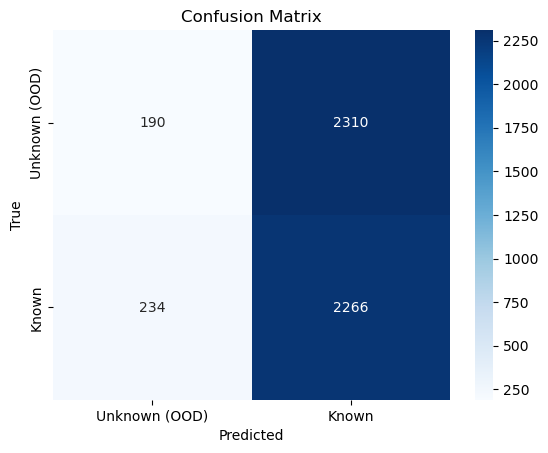

In [115]:
print_evaluation_report(is_known, predictions)

In [116]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.025712  -0.038503   0.064626   0.017860        bird
1      1    0.024228  -0.046683   0.067649   0.018110         cat
2      2    0.024697  -0.065173   0.076901   0.018011        deer
3      3    0.024166  -0.036989   0.069823   0.017238         dog
4      4    0.024535  -0.049131   0.067402   0.018135        frog
5      5    0.025554  -0.037437   0.065844   0.017760       horse
6      6    0.025412  -0.030297   0.068267   0.017229        ship
7      7    0.024119  -0.035218   0.064993   0.018086       truck
8      8    0.017856  -0.020065   0.057818   0.016058  automobile
9      9    0.032774  -0.008496   0.063566   0.015390    airplane


In [117]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     16        bird
1      1     18         cat
2      2      7        deer
3      3     29         dog
4      4     12        frog
5      5     64       horse
6      6     16        ship
7      7     72       truck
8      8    144  automobile
9      9     46    airplane


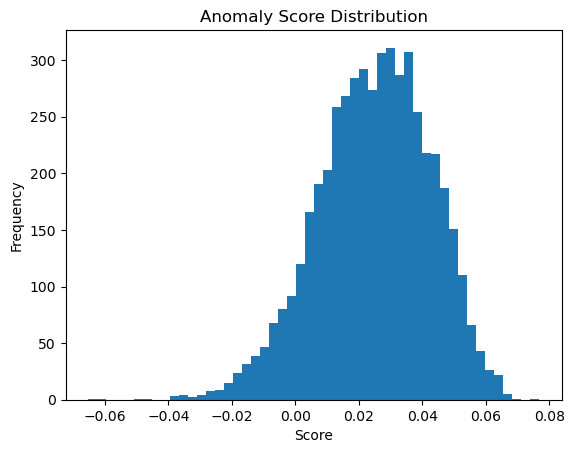

In [118]:
show_anomaly_score_plot(anomaly_scores)

## Dense layer features

In [119]:
train_features_dense = dense_output_model.predict(subset_train_flow, verbose=1)
test_features_dense =  dense_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 128ms/step


In [120]:
train_features_dense.shape

(5000, 128)

In [121]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_dense, 
    test_features = test_features_dense
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 45.64%
               precision    recall  f1-score   support

Unknown (OOD)       0.11      0.01      0.02      2500
        Known       0.48      0.90      0.62      2500

     accuracy                           0.46      5000
    macro avg       0.30      0.46      0.32      5000
 weighted avg       0.30      0.46      0.32      5000



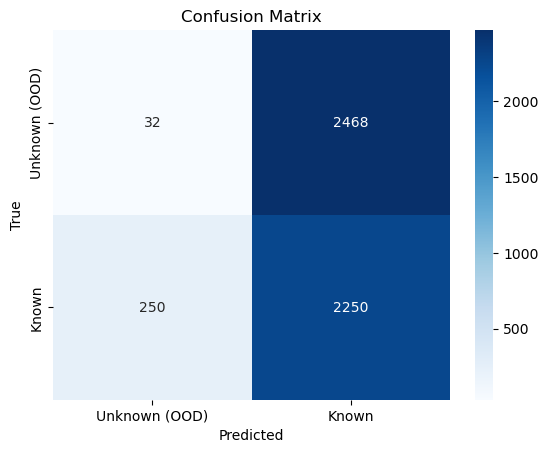

In [122]:
print_evaluation_report(is_known, predictions)

In [123]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.067599  -0.087826   0.130090   0.039892        bird
1      1    0.070290  -0.095399   0.133758   0.036238         cat
2      2    0.070525  -0.088602   0.127090   0.037227        deer
3      3    0.068825  -0.052837   0.131539   0.037541         dog
4      4    0.069799  -0.080116   0.128412   0.036752        frog
5      5    0.069105  -0.083794   0.124737   0.041174       horse
6      6    0.067724  -0.125783   0.131744   0.038821        ship
7      7    0.069284  -0.112051   0.133704   0.041119       truck
8      8    0.076081  -0.033072   0.125174   0.030189  automobile
9      9    0.090380   0.010289   0.128173   0.021701    airplane


In [124]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     15        bird
1      1     10         cat
2      2     13        deer
3      3     29         dog
4      4     51        frog
5      5     43       horse
6      6     43        ship
7      7     46       truck
8      8     32  automobile


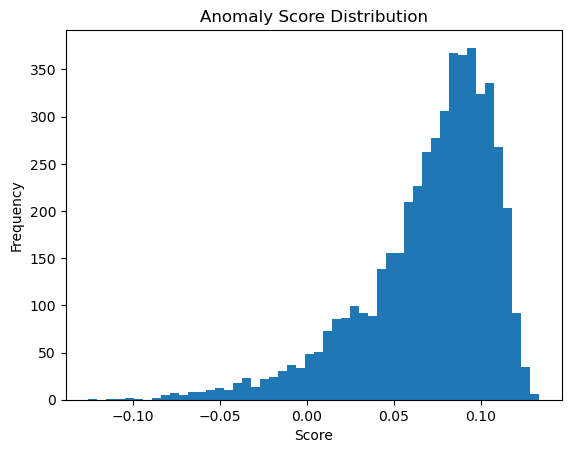

In [125]:
show_anomaly_score_plot(anomaly_scores)

## Logits

In [126]:
train_features_logits = logits_model.predict(subset_train_flow, verbose=1)
test_features_logits =  logits_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 129ms/step


In [127]:
train_features_logits.shape

(5000, 8)

In [128]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = test_features_logits
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 45.60%
               precision    recall  f1-score   support

Unknown (OOD)       0.18      0.02      0.04      2500
        Known       0.48      0.89      0.62      2500

     accuracy                           0.46      5000
    macro avg       0.33      0.46      0.33      5000
 weighted avg       0.33      0.46      0.33      5000



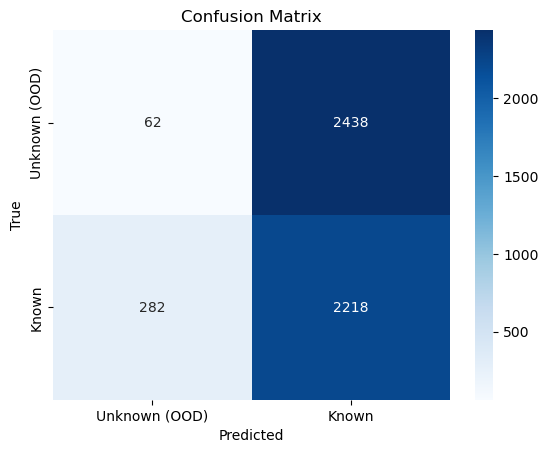

In [129]:
print_evaluation_report(is_known, predictions)

In [130]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.077172  -0.168136   0.140991   0.046119        bird
1      1    0.079751  -0.141922   0.144409   0.043952         cat
2      2    0.078490  -0.146565   0.143014   0.046643        deer
3      3    0.075857  -0.158860   0.146957   0.048474         dog
4      4    0.078728  -0.132585   0.141756   0.048106        frog
5      5    0.079135  -0.176240   0.144235   0.050032       horse
6      6    0.077367  -0.173177   0.145322   0.047426        ship
7      7    0.077610  -0.114972   0.141720   0.047281       truck
8      8    0.077174  -0.084624   0.136576   0.037886  automobile
9      9    0.100776  -0.000089   0.143075   0.026864    airplane


In [131]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0      1        bird
1      1      2         cat
2      2     28        deer
3      3     40         dog
4      4     32        frog
5      5    100       horse
6      6     19        ship
7      7     60       truck
8      8     57  automobile
9      9      5    airplane


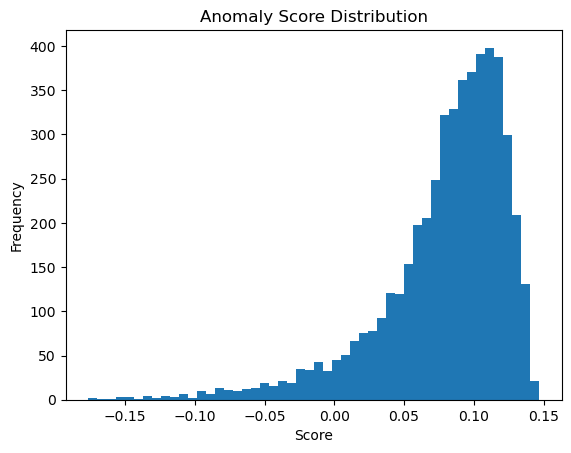

In [132]:
show_anomaly_score_plot(anomaly_scores)

## Model output

In [133]:
train_features = my_model.predict(subset_train_flow, verbose=1)
test_features =  my_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 127ms/step


In [134]:
train_features.shape

(5000, 8)

In [135]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features, 
    test_features = test_features
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 60.84%
               precision    recall  f1-score   support

Unknown (OOD)       0.79      0.29      0.43      2500
        Known       0.57      0.92      0.70      2500

     accuracy                           0.61      5000
    macro avg       0.68      0.61      0.56      5000
 weighted avg       0.68      0.61      0.56      5000



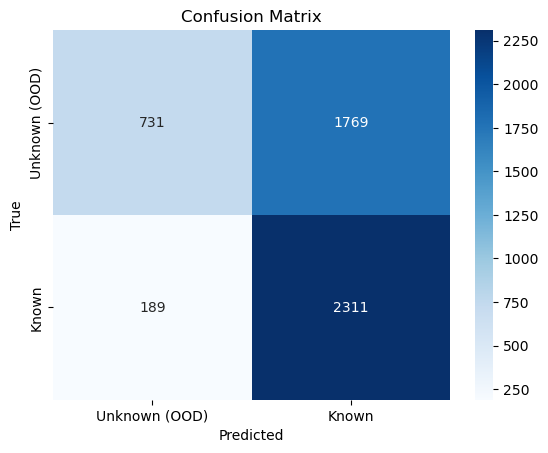

In [136]:
print_evaluation_report(is_known, predictions)

In [137]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.046181  -0.043929   0.110701   0.041026        bird
1      1    0.044566  -0.051685   0.110701   0.039499         cat
2      2    0.045384  -0.043564   0.110701   0.040345        deer
3      3    0.043894  -0.054843   0.110701   0.043323         dog
4      4    0.043271  -0.049280   0.110701   0.042320        frog
5      5    0.042917  -0.044043   0.110701   0.041525       horse
6      6    0.044658  -0.060783   0.110701   0.040289        ship
7      7    0.042152  -0.044584   0.110701   0.043080       truck
8      8    0.050738  -0.052406   0.110701   0.049130  automobile
9      9    0.015747  -0.050489   0.109704   0.036093    airplane


In [138]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     13        bird
1      1     38         cat
2      2     22        deer
3      3     15         dog
4      4      2        frog
5      5     55       horse
6      6     20        ship
7      7     24       truck
8      8    266  automobile
9      9    465    airplane


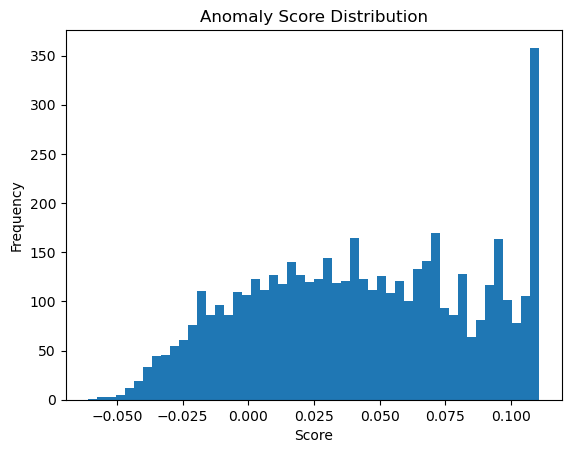

In [139]:
show_anomaly_score_plot(anomaly_scores)